In [ ]:
# kernal dead
import os
import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mne.decoding import CSP
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

# -------------------------
# Setup
# -------------------------
data_dir = '/storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/processed_data3'
processed_dir = '/storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/csp_processed'
os.makedirs(processed_dir, exist_ok=True)

# -------------------------
# Step 1: Collect file paths
# -------------------------
files = glob.glob(os.path.join(data_dir, '*.npz'))
print(f"Found {len(files)} data files")

# -------------------------
# Step 2: Split files for train/test
# -------------------------
train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

# -------------------------
# Step 3: Fit CSP on training files
# -------------------------
print("Fitting CSP on batch-wise training data...")
X_csp_fit, y_csp_fit = [], []

for file in train_files:
    data = np.load(file)
    X = data['X'].astype(np.float64)  # Convert to float64
    y = data['y']
    X_csp_fit.append(X)
    y_csp_fit.append(y)

X_csp_fit = np.concatenate(X_csp_fit, axis=0)
y_csp_fit = np.concatenate(y_csp_fit, axis=0)

# Convert full dataset to float64 before fitting CSP
X_csp_fit = X_csp_fit.astype(np.float64)

# CSP expects shape (n_epochs, n_channels, n_times)
csp = CSP(n_components=6, reg=None, log=True, norm_trace=False)
csp.fit(X_csp_fit, y_csp_fit)

# -------------------------
# Step 4: Transform and save CSP features
# -------------------------
def save_csp_features(file_list, split):
    for idx, file in enumerate(file_list):
        data = np.load(file)
        X = data['X'].astype(np.float64)  # Ensure float64 here too
        y = data['y']
        X_csp = csp.transform(X)
        out_file = os.path.join(processed_dir, f"{split}_{idx:04d}.npz")
        np.savez_compressed(out_file, X=X_csp, y=y)
        print(f"Saved {out_file}")

print("Processing train files...")
save_csp_features(train_files, 'train')

print("Processing test files...")
save_csp_features(test_files, 'test')

# -------------------------
# Step 5: Dataset for PyTorch
# -------------------------
class CSPDataset(Dataset):
    def __init__(self, split='train'):
        self.files = sorted(glob.glob(os.path.join(processed_dir, f'{split}_*.npz')))
        self.index_map = []
        for file_idx, f in enumerate(self.files):
            data = np.load(f)
            self.index_map.extend([(file_idx, i) for i in range(data['X'].shape[0])])
        self.split = split

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        file_idx, sample_idx = self.index_map[idx]
        data = np.load(self.files[file_idx])
        X = data['X'][sample_idx]
        y = data['y'][sample_idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

train_dataset = CSPDataset(split='train')
test_dataset = CSPDataset(split='test')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# -------------------------
# Transformer Model
# -------------------------
class EEGTransformer(nn.Module):
    def __init__(self, input_dim, num_classes=2, d_model=64, nhead=8, num_layers=2, dim_feedforward=128, dropout=0.1):
        super(EEGTransformer, self).__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, input_dim, d_model))
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_model * input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        x = self.embedding(x)
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2).contiguous()
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# -------------------------
# Training
# -------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EEGTransformer(input_dim=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

# -------------------------
# Evaluation
# -------------------------
model.eval()
all_preds, all_probs = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(out, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_probs.extend(probs)

y_test = np.concatenate([np.load(f)['y'] for f in test_dataset.files])
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

acc = accuracy_score(y_test, all_preds)
roc_auc = roc_auc_score(y_test, all_probs)
print(f"Test Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# -------------------------
# Plotting
# -------------------------
fpr, tpr, _ = roc_curve(y_test, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()

cm = confusion_matrix(y_test, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pronation', 'Supination'],
            yticklabels=['Pronation', 'Supination'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Found 70 data files
Fitting CSP on batch-wise training data...
Computing rank from data with rank=None


Found 70 data files
Fitting CSP on batch-wise training data...
Computing rank from data with rank=None
    Using tolerance 1.2e+02 (2.2e-16 eps * 60 dim * 8.9e+15  max singular value)
    Estimated rank (data): 60
    data: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Processing train files...
Saved /storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/csp_processed/train_0000.npz
Saved /storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/csp_processed/train_0001.npz
Saved /storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/csp_processed/train_0002.npz
Saved /storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/csp_processed/train_0003.npz
Saved /storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/csp_processed/train_0004.npz
Saved /storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/csp_processed/train_0005.npz
Saved /storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/csp_

/storage/projects1/e19-4yp-mi-eeg-for-bci/env/preprocess-env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/30, Loss: 0.6999
Epoch 2/30, Loss: 0.6939
Epoch 3/30, Loss: 0.6938
Epoch 4/30, Loss: 0.6938
Epoch 5/30, Loss: 0.6932
Epoch 6/30, Loss: 0.6925
Epoch 7/30, Loss: 0.6924
Epoch 8/30, Loss: 0.6919
Epoch 9/30, Loss: 0.6935
Epoch 10/30, Loss: 0.6916
Epoch 11/30, Loss: 0.6919
Epoch 12/30, Loss: 0.6927
Epoch 13/30, Loss: 0.6920
Epoch 14/30, Loss: 0.6909
Epoch 15/30, Loss: 0.6906
Epoch 16/30, Loss: 0.6914
Epoch 17/30, Loss: 0.6916
Epoch 18/30, Loss: 0.6899
Epoch 19/30, Loss: 0.6912
Epoch 20/30, Loss: 0.6899
Epoch 21/30, Loss: 0.6916
Epoch 22/30, Loss: 0.6906
Epoch 23/30, Loss: 0.6907
Epoch 24/30, Loss: 0.6900
Epoch 25/30, Loss: 0.6903
Epoch 26/30, Loss: 0.6901
Epoch 27/30, Loss: 0.6895
Epoch 28/30, Loss: 0.6908
Epoch 29/30, Loss: 0.6901
Epoch 30/30, Loss: 0.6906
Test Accuracy: 0.4930
ROC AUC Score: 0.4915


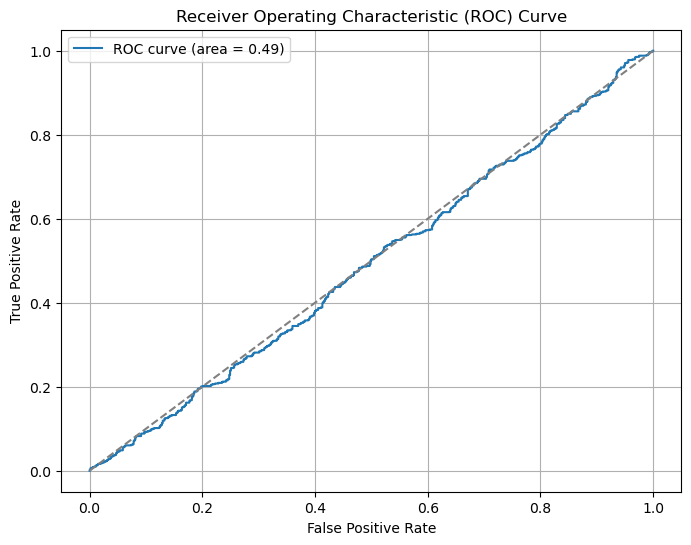

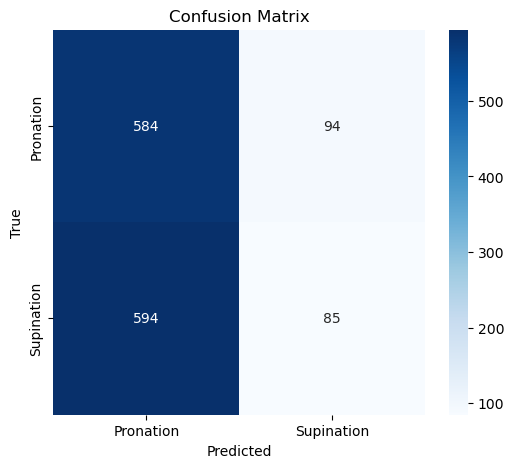

In [1]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from mne.decoding import CSP
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import gc
import time

# -------------------------
# Setup
# -------------------------
data_dir = '/storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/processed_data3'
processed_dir = '/storage/projects1/e19-4yp-mi-eeg-for-bci/ashan/csp_processed'
os.makedirs(processed_dir, exist_ok=True)

# -------------------------
# Step 1: Collect file paths
# -------------------------
files = glob.glob(os.path.join(data_dir, '*.npz'))
print(f"Found {len(files)} data files")

# -------------------------
# Step 2: Split files for train/test
# -------------------------
train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

# -------------------------
# Step 3: Fit CSP on training files
# -------------------------
print("Fitting CSP on batch-wise training data...")
X_csp_fit, y_csp_fit = [], []

for file in train_files:
    data = np.load(file)
    X, y = data['X'], data['y']
    X_csp_fit.append(X)
    y_csp_fit.append(y)
    data.close()

X_csp_fit = np.concatenate(X_csp_fit, axis=0).astype(np.float64)  # CSP requires double precision
y_csp_fit = np.concatenate(y_csp_fit, axis=0)

# CSP expects shape (n_epochs, n_channels, n_times)
csp = CSP(n_components=6, reg=None, log=True, norm_trace=False)
csp.fit(X_csp_fit, y_csp_fit)

# -------------------------
# Step 4: Transform and save CSP features
# -------------------------
def save_csp_features(file_list, split):
    for idx, file in enumerate(file_list):
        data = np.load(file)
        X, y = data['X'], data['y']
        data.close()
        X_csp = csp.transform(X)
        out_file = os.path.join(processed_dir, f"{split}_{idx:04d}.npz")
        np.savez_compressed(out_file, X=X_csp, y=y)
        print(f"Saved {out_file}")

print("Processing train files...")
save_csp_features(train_files, 'train')

print("Processing test files...")
save_csp_features(test_files, 'test')

# -------------------------
# Step 5: Dataset for PyTorch with lazy loading and caching
# -------------------------
class CSPDataset(Dataset):
    def __init__(self, split='train'):
        self.files = sorted(glob.glob(os.path.join(processed_dir, f'{split}_*.npz')))
        self.file_cache = {}
        self.index_map = []
        for f_idx, f in enumerate(self.files):
            data = np.load(f)
            length = data['y'].shape[0]
            data.close()
            self.index_map.extend([(f_idx, i) for i in range(length)])

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        f_idx, sample_idx = self.index_map[idx]
        f = self.files[f_idx]
        if f not in self.file_cache:
            self.file_cache[f] = np.load(f)
        data = self.file_cache[f]
        X = data['X'][sample_idx]
        y = data['y'][sample_idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

    def clear_cache(self):
        for f in self.file_cache.values():
            f.close()
        self.file_cache = {}

train_dataset = CSPDataset(split='train')
test_dataset = CSPDataset(split='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)

# -------------------------
# Transformer Model
# -------------------------
class EEGTransformer(nn.Module):
    def __init__(self, input_dim, num_classes=2, d_model=64, nhead=8, num_layers=2, dim_feedforward=128, dropout=0.1):
        super(EEGTransformer, self).__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, input_dim, d_model))
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_model * input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        x = self.embedding(x)
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2).contiguous()
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# -------------------------
# Training
# -------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EEGTransformer(input_dim=6).to(device)

criterion = nn.CrossEntropyLoss()

# Make sure no variable named 'Adam' shadows torch.optim.Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # Explicitly delete to free memory
        del xb, yb, output, loss
        torch.cuda.empty_cache()
        gc.collect()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")
    time.sleep(1)  # Give the system a small rest each epoch

    # Clear dataset cache to free memory if needed
    train_dataset.clear_cache()
    test_dataset.clear_cache()

# -------------------------
# Evaluation
# -------------------------
model.eval()
all_preds, all_probs = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(out, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_probs.extend(probs)
        del xb, out, probs, preds
        torch.cuda.empty_cache()
        gc.collect()

y_test = np.concatenate([np.load(f)['y'] for f in test_dataset.files])
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

acc = accuracy_score(y_test, all_preds)
roc_auc = roc_auc_score(y_test, all_probs)
print(f"Test Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# -------------------------
# Plotting
# -------------------------
fpr, tpr, _ = roc_curve(y_test, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()

cm = confusion_matrix(y_test, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pronation', 'Supination'],
            yticklabels=['Pronation', 'Supination'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
